In [1]:
#IDEAS
#https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html
#http://sbfnk.github.io/mfiidd/mcmc_diagnostics.html
#https://cran.r-project.org/web/packages/ggmcmc/vignettes/v70i09.pdf

# Advance Statistics for physical analysis project:

# Study of the energy resolution and uncertainties of germanium detectors using bayesian methods


<b>Students</b> : 
   
   - Hilario Capettini
   - João Freitas 
    
<b>Professor</b> :
   
   - Alberto Garfagnini

# Theory

We have a file containing counts for different channels. These counts were obtained with a Germanium detector irradiated by a combination of three sources $^{241}\text{Am}$, $^{60}\text{Co}$, $^{137}\text{Cs}$. 

Our goal is to characterize the peaks of the signal assigning to them a position $x_i$, a width $w_i$, an amplitude $A_i$ and also to decouple them from the noise characterizing it with an amplitude $B_i$, the subindex $i=1,...,n$ implies that these quantities are specific for each peak in the signal. 

So, given the counts $\{N_k\}$ measured at the values $\{x_k\}$ we want the best estimates for $x_i, \; w_i, \; A_i, \; B_i$ characterizing the noise and the signal peaks. 
In this case we have a photon spectrum were the number of photons was measured by bins of energy. This number is proportional to the exposure $\Delta t$ (the time that we have been measuring) and the other variables that we are considering through the following formula:

$$ S_k = \Delta t \left[A \text{exp}\left(-\frac{(x_k-x_0)^2}{2 w^2}\right)+B\right]  $$

The number of observed photons, $\lambda$, is an integer number and follows the Poisson distribution

$$P(\lambda|S)= \frac{S^\lambda e^{-S}}{\lambda!}$$

as each event is independent from the others, we can obtain the likelihood just by multiplying the Poisson distribution

$$P(D|\theta,M)= \prod_j \frac{S_k^{\lambda_k}e^{-S_k}}{\lambda_k!} $$

were we are using $\theta=(A,B,w,X_0)$

In [2]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
#library(tidyverse)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

Loading required package: sysfonts
Loading required package: showtextdb
Warning message:
“package ‘rjags’ was built under R version 3.6.3”Loading required package: coda
Warning message:
“package ‘coda’ was built under R version 3.6.3”Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


# Data loading and visualization

## Loading

In [3]:
data <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 
#r_data <- read.csv("data/IC48A_AmCsCo.txt",header=TRUE, sep="\t")

#Data must be passed in list form
#data  <- NULL
#data$x <- r_data[[1]]  
#data$y <- r_data[[2]]

## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

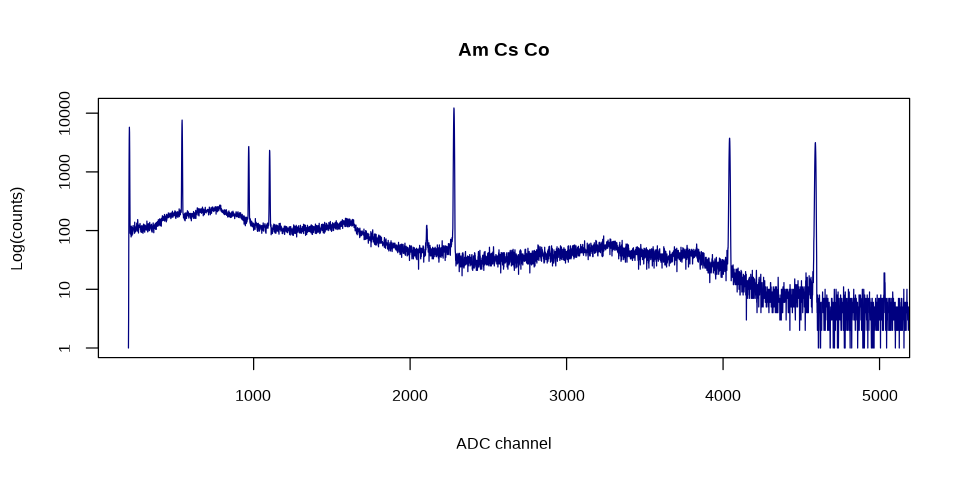

In [4]:
set_plot_dimensions(8, 4)

plot(data$Ch,data$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [4]:
#Add tble with the energies and so on, all what we will be needing/using along the notebook
#and is external

## Peak detection and characterization

In [5]:
#Integrate Joaos function to detect and characterize the peaks.
#We basically need invervals containing the peaks and their maximums.

In [6]:
range_size <- function(data){
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    peak_idx <- which.max(peak_array)
    
    #centered_peak <- vector(length = 1, mode = 'double')
    centered_peak <- c(peak_array[(peak_idx-10):(peak_idx+10)])
    return(centered_peak)
}

probe_peaks <- function(data, n.pts){
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ranges <- lapply(data_range, range_size)
    peaks <- data_range[ranges > 1500]
    l <- lapply(peaks, peak_shift)
    centered_peaks <- data.frame(matrix(unlist(l), ncol=length(l)))
    centered_peaks$x_vals <- c(1:nrow(centered_peaks))
    return(centered_peaks)
}

In [7]:
centered_peaks <- probe_peaks(data, 80) #%>% pivot_longer(!x_vals, values_to = c('counts'), names_to='peak')

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
“data length is not a multiple of split variable”Warning message in matrix(unlist(l), ncol = length(l)):
“data length [146] is not a sub-multiple or multiple of the number of rows [21]”

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'counts' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(c

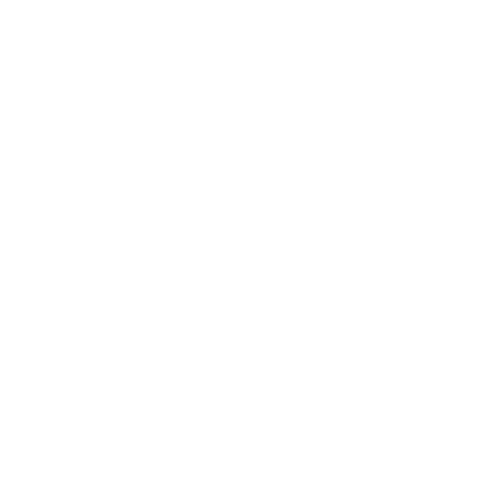

In [35]:
ggplot(data = centered_peaks, mapping = aes(x = x_vals, y = counts, color = factor(peak))) + geom_line() + geom_point()

In [73]:
#Working intervals
#Peak one   x0 [200:220]
#Peak two   x0 [530:560]
#Peak three x0 [900:1000] Atention with the amplitude A[2000:3000]
#Peak four x0 [1080:1120] Atention with the amplitude A[2000:3000]

In [5]:
#We reduce the data to the vicinity of the choosen peak
peak_1.data <- NULL
peak_1.data$x <- data$Ch[1080:1120] 
peak_1.data$y <- data$counts[1080:1120]

# Peak processing 

## Peak display

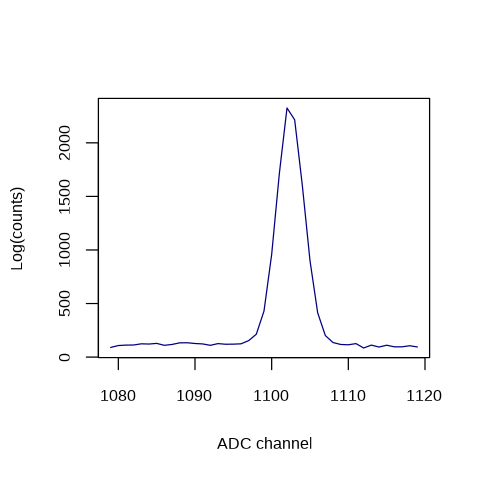

In [6]:
#Plot of the choosen peak
set_plot_dimensions(4, 4)

plot(peak_1.data$x,peak_1.data$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel")

## BUGS model

In [7]:
#The model is defined in a .bug (txt) file
#To easily modify the intervals we manage it from the notebook

#The interval for the priors are very importants!
a<-2000
b<-3000
cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(",a,",",b,")
    B ~ dunif(0,600)

    x0 ~ dunif(1080,1120)
    w ~ dunif(1,10)
      
}", file="Models/model_1.bug")

model <- "Models/model_1.bug"

## Convergence studies 

### Chain initializations

In [8]:
#If multiple chains are run, each of them need to be initialized
init_1_1 <- NULL;init_1_1$A  <- 2500;  init_1_1$B  <- 0;   init_1_1$w  <- 5; init_1_1$x0 <- 1100
init_1_2 <- NULL;init_1_2$A  <- 2500;  init_1_2$B  <- 100; init_1_2$w  <- 5; init_1_2$x0 <- 1100
init_1_3 <- NULL;init_1_3$A  <- 2500; init_1_3$B  <- 200; init_1_3$w  <- 5; init_1_3$x0 <- 1100

#To have absolute control we also set the seed for and random number generator for each chain
init_1 <- list(c(init_1_1,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_1_2,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init_1_3,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"))


### Run JAGS

In [9]:
chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10

In [10]:
jm <- jags.model(model,
                 peak_1.data,
                 inits=init_1,
                 n.chains=chain_number)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 41
   Unobserved stochastic nodes: 4
   Total graph size: 384

Initializing model



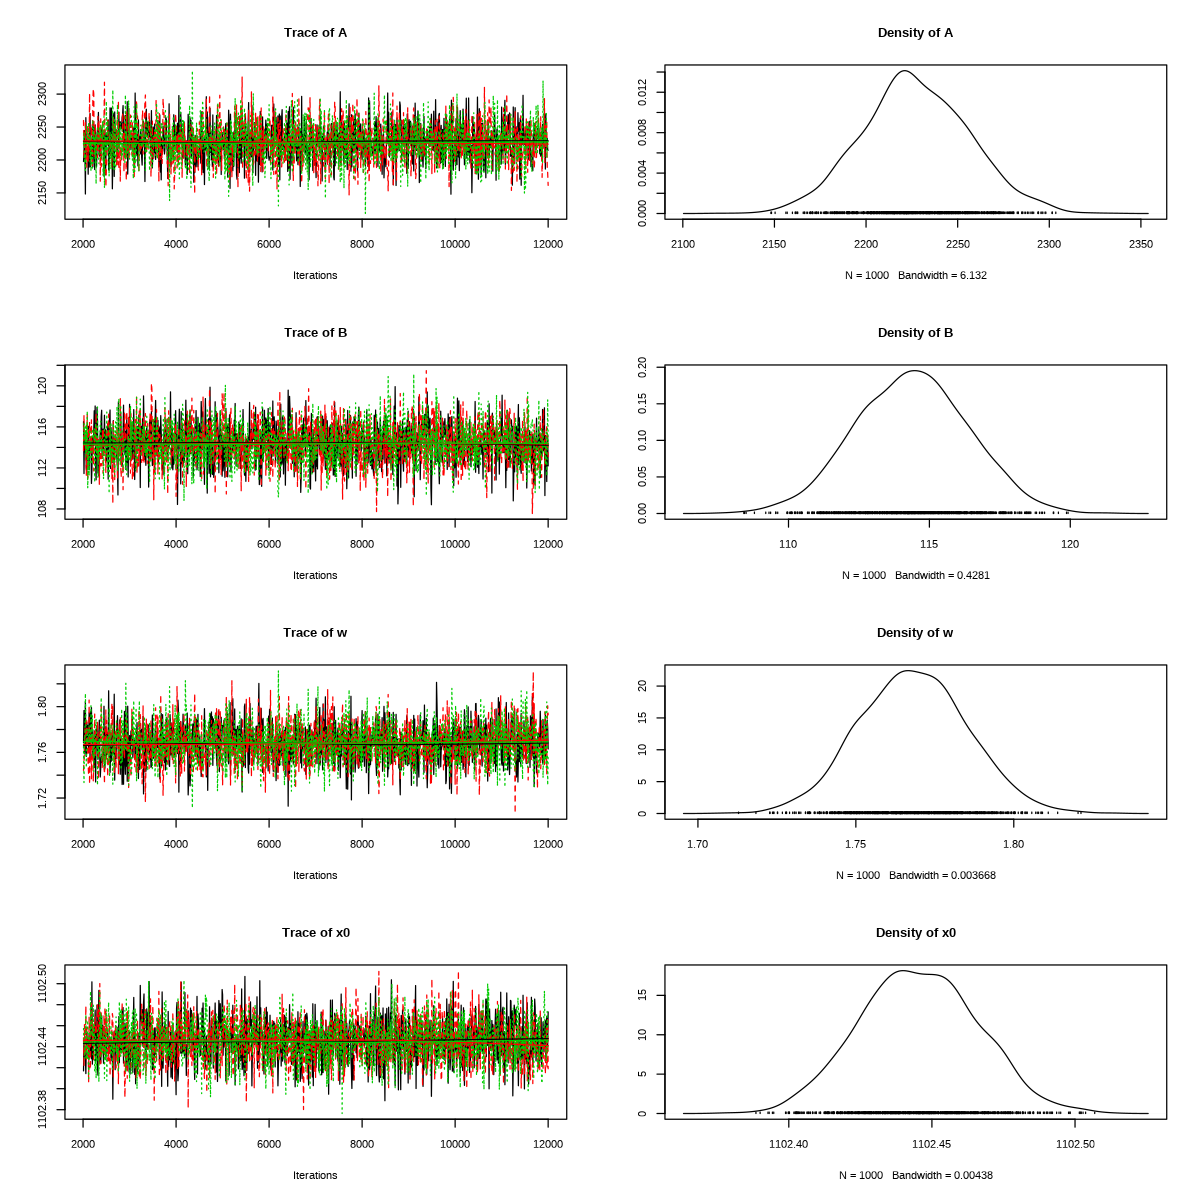

In [11]:
#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
plot(chain)

### Chain autocorrelation

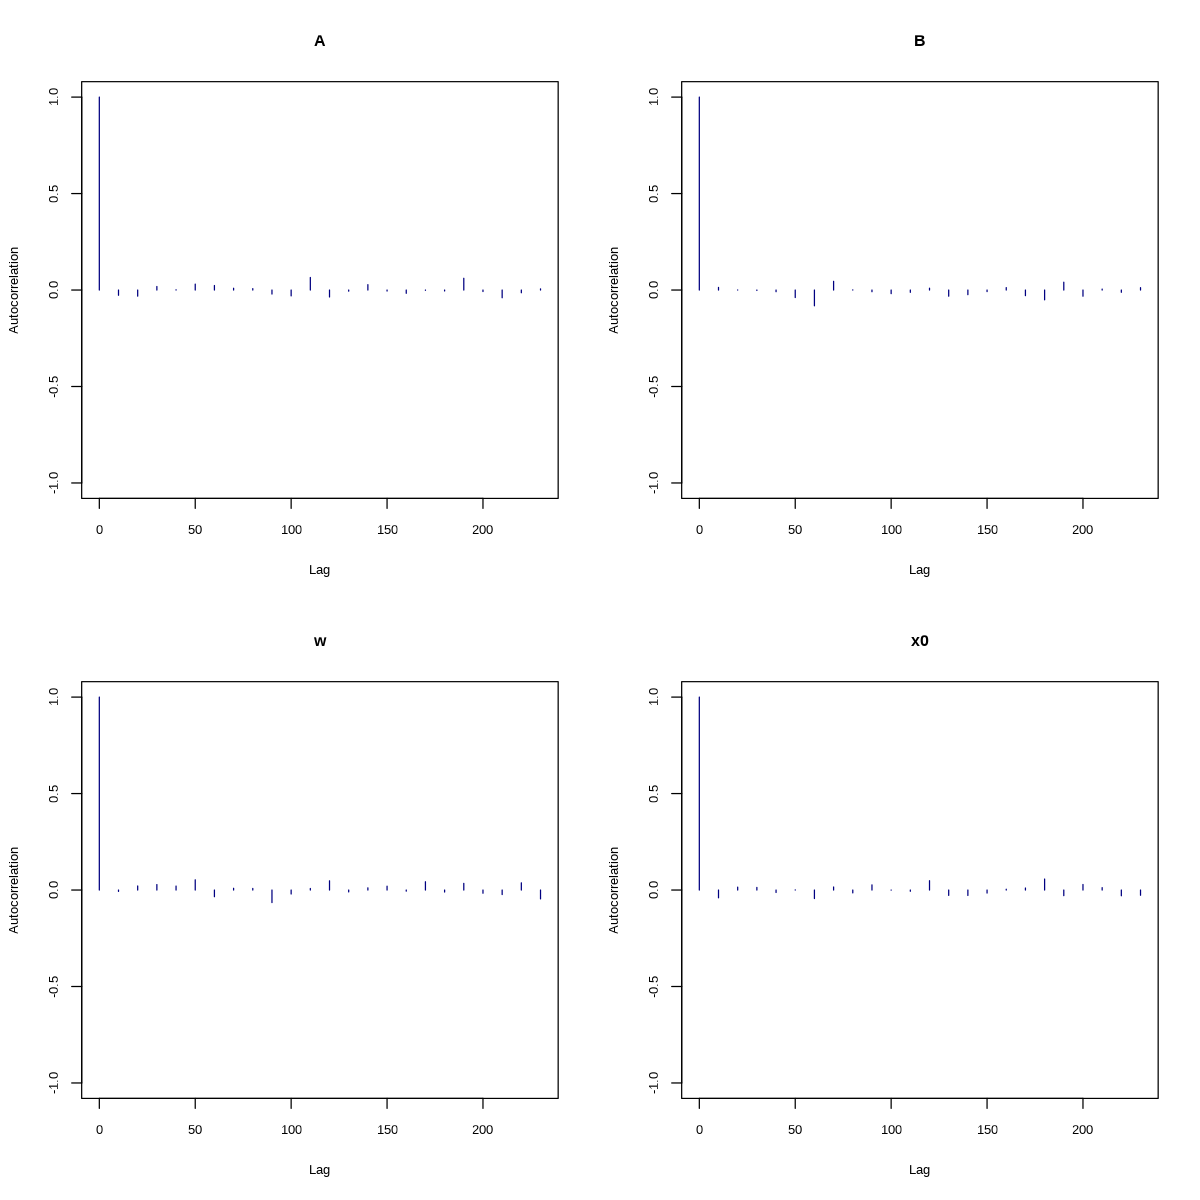

In [12]:
#Autocorrelation plots
autocorr.plot(chain[[1]], col='navy')

### Burn-in effect on autocorrelation

### Thining effect on autocorrelation

### Parameter correlations

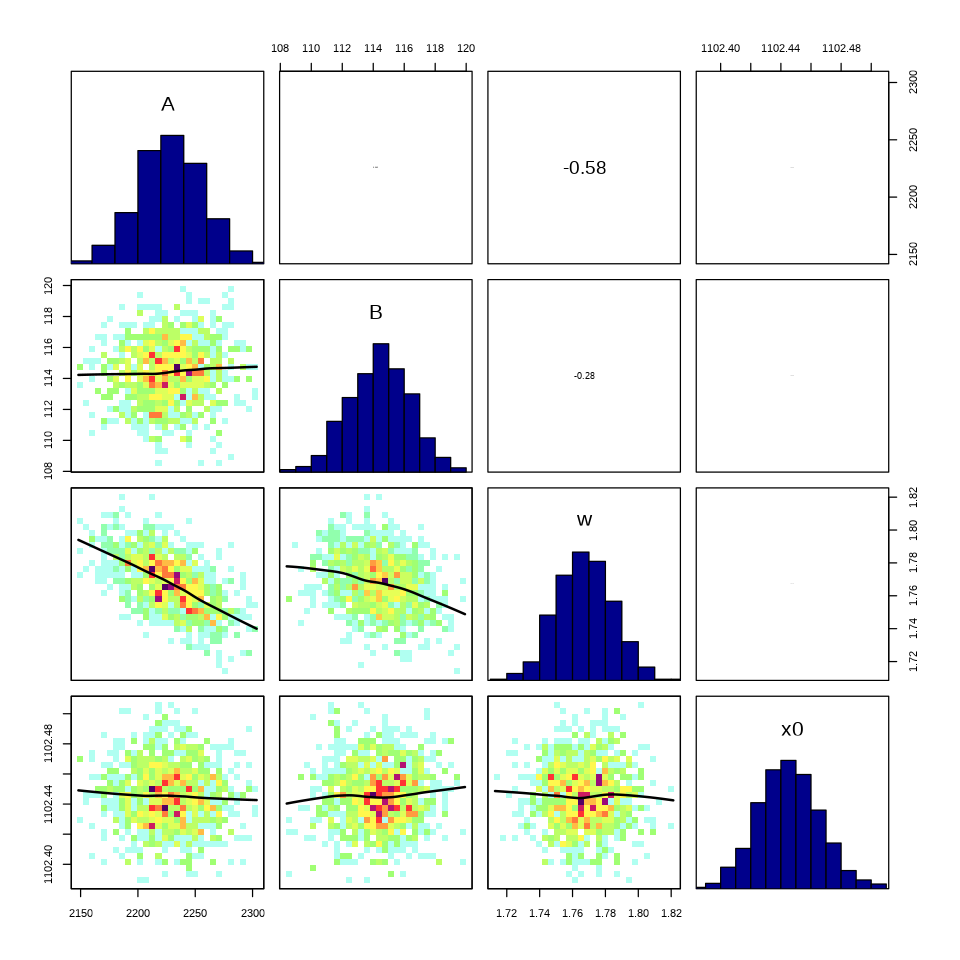

In [92]:
set_plot_dimensions(8, 8)
correlationPlot((chain))

### Gelman diagnostic of the multiple chains

Potential scale reduction factors:

   Point est. Upper C.I.
A           1       1.01
B           1       1.00
w           1       1.01
x0          1       1.00

Multivariate psrf

1

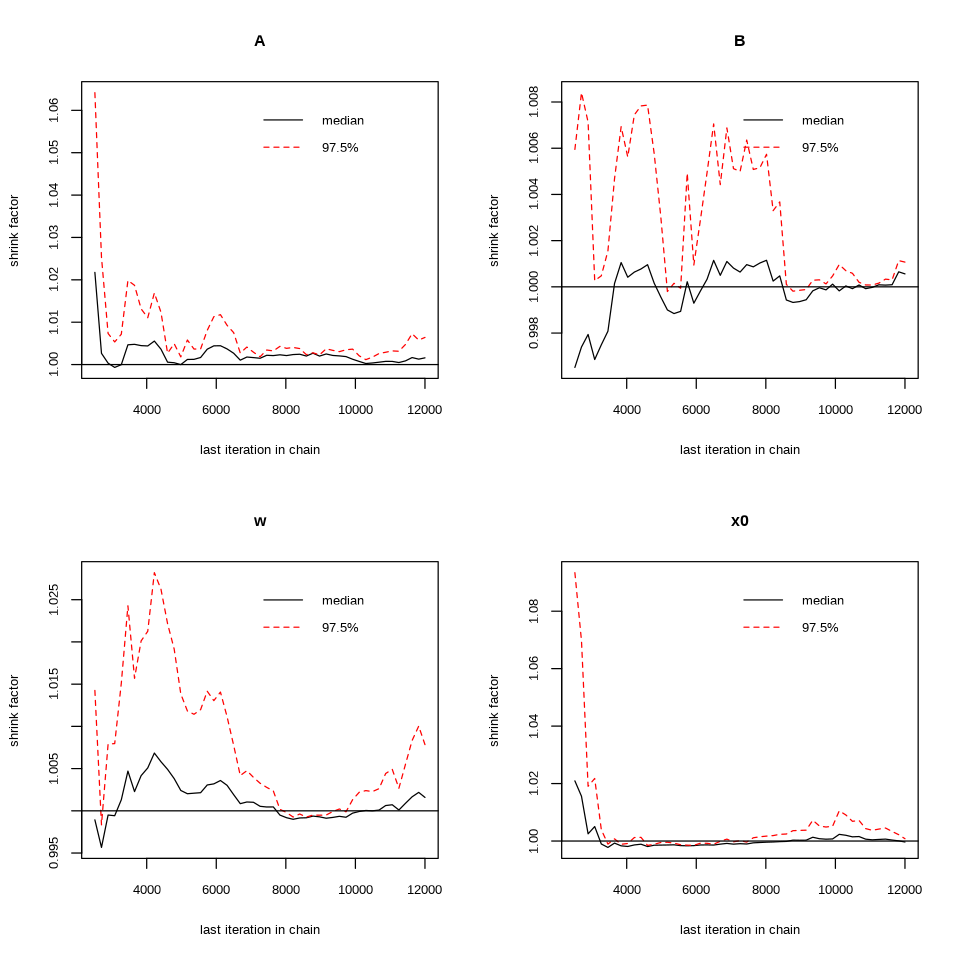

In [93]:
gelman.diag(chain)
gelman.plot(chain)

### MCMC results for the parameters

In [94]:
summary(chain)


Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  2227.038 29.23865 0.5338223      0.5338769
B   114.376  2.00285 0.0365669      0.0365784
w     1.768  0.01716 0.0003133      0.0003132
x0 1102.445  0.02049 0.0003741      0.0003742

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  2169.955 2208.225 2225.953 2246.67 2286.274
B   110.441  112.986  114.385  115.71  118.223
w     1.735    1.756    1.768    1.78    1.802
x0 1102.406 1102.431 1102.445 1102.46 1102.485


### Distributions and confidence intervals

In [95]:
#write code to obtain some bar plots under the pdf and lines stating the confidence intervals
#
#
#

### Results presentation

In [96]:
#Table with the results
#
#
#

In [98]:
A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x <- seq(1080,1120,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)

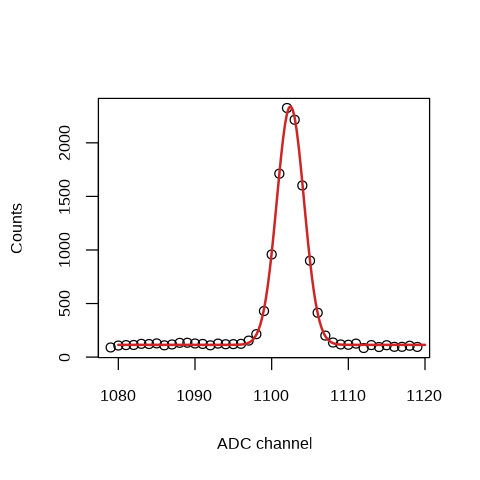

In [99]:
set_plot_dimensions(4, 4)

plot(peak_1.data$x,peak_1.data$y,
    ylab = "Counts", xlab ="ADC channel")
lines(x,f, lwd=2, col='firebrick3')

In [15]:
#Working intervals
#Peak one   x0 [200:220]
#Peak two   x0 [530:560]
#Peak three x0 [900:1000] Atention with the amplitude A[2000:3000]
#Peak four x0 [1080:1120] Atention with the amplitude A[2000:3000]

In [56]:
t1 <- NULL
t1$x <- data$Ch[203:220]
t1$y <- data$counts[203:220]

t2 <- NULL
t2$x <- data$Ch[530:560] 
t2$y <- data$counts[530:560]

t3 <- NULL
t3$x <- data$Ch[900:1000] 
t3$y <- data$counts[900:1000]

t4 <- NULL
t4$x <- data$Ch[1080:1120]
t4$y <- data$counts[1080:1120]


peaks <-list(t1,t2,t3,t4)

[1] "peak 1"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  5668.798 47.203466 0.8618134      0.8831737
B    71.661  0.338834 0.0061862      0.0062790
w     1.282  0.007385 0.0001348      0.0001394
x0  206.185  0.009870 0.0001802      0.0001802

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  5571.242 5638.020 5671.361 5703.816 5749.858
B    70.736   71.534   71.765   71.899   71.989
w     1.268    1.277    1.282    1.287    1.297
x0  206.166  206.179  206.185  206.192  206.205



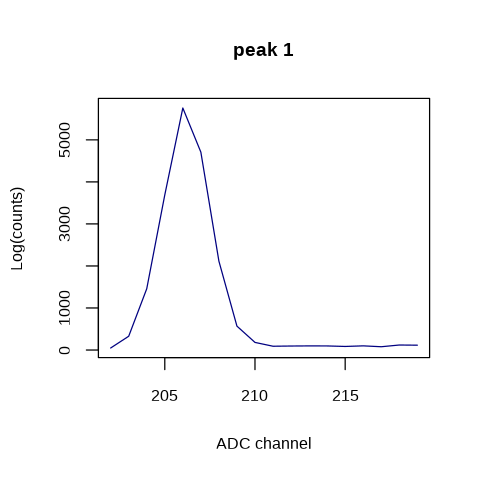

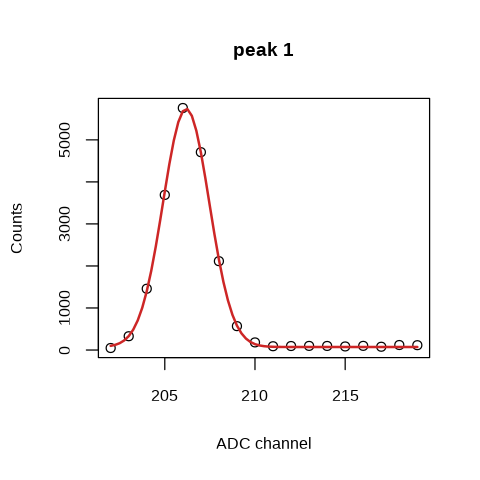

[1] "peak 2"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
A  7377.113 56.138105 1.0249369      1.0426289
B   190.117  2.990519 0.0545992      0.0524971
w     1.543  0.008020 0.0001464      0.0001486
x0  542.816  0.009916 0.0001810      0.0001811

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
A  7269.235 7337.924 7376.722 7414.265 7491.433
B   184.231  188.181  190.093  192.089  196.165
w     1.528    1.537    1.543    1.548    1.559
x0  542.796  542.809  542.816  542.822  542.835



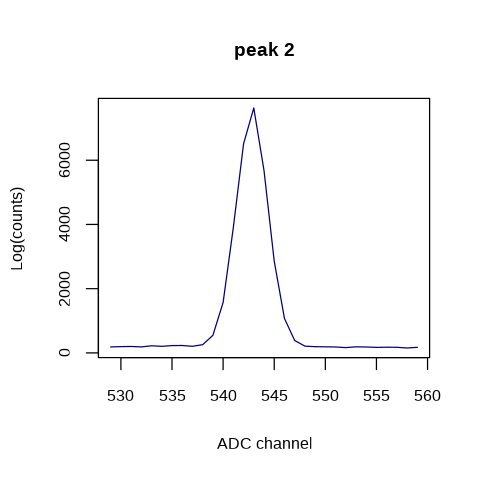

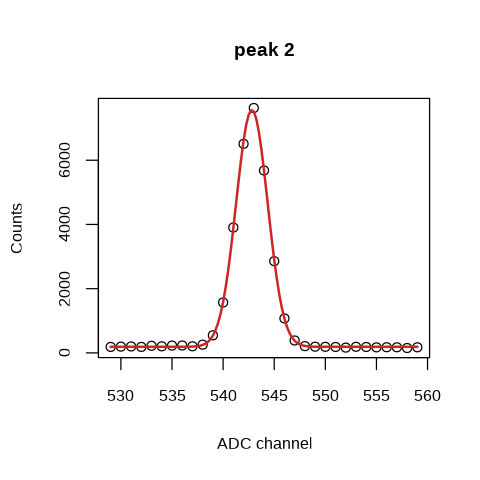

[1] "peak 3"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
A  1797.63 1188.850 21.705325      0.4773912
B   162.45    8.228  0.150220      0.0192957
w     1.43    0.297  0.005423      0.0002465
x0  960.72   11.324  0.206755      0.0027648

2. Quantiles for each variable:

      2.5%     25%     50%      75%    97.5%
A  116.093 117.451 2616.35 2649.141 2691.325
B  154.330 156.230  157.55  173.971  173.999
w    1.001   1.015    1.63    1.644    1.666
x0 944.327 944.884  968.72  968.733  968.759



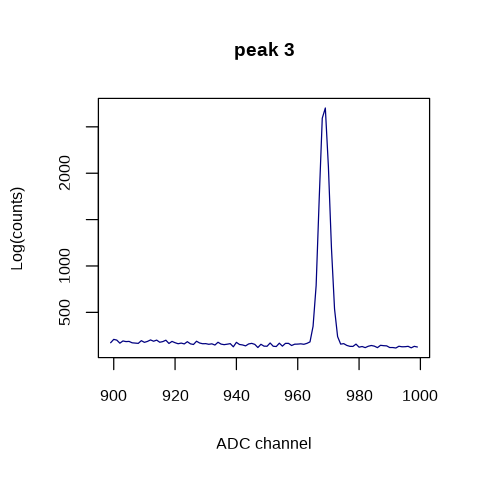

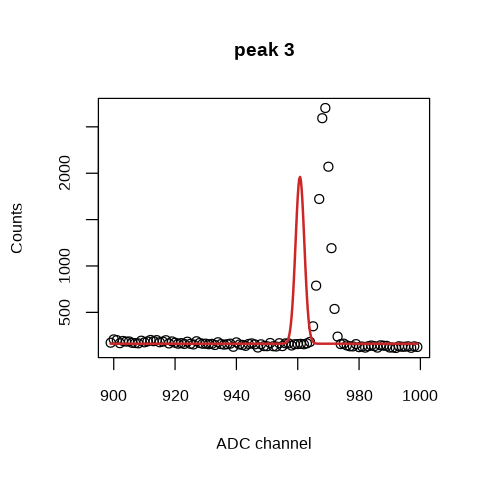

[1] "peak 4"

Iterations = 2010:12000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean       SD  Naive SE Time-series SE
A  2227.293 29.98260 0.5474050      0.5685821
B   114.287  1.96734 0.0359186      0.0337655
w     1.768  0.01750 0.0003195      0.0003195
x0 1102.445  0.02018 0.0003684      0.0003805

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
A  2169.532 2206.838 2226.841 2247.64 2285.868
B   110.464  112.952  114.281  115.66  118.116
w     1.735    1.756    1.768    1.78    1.803
x0 1102.406 1102.432 1102.445 1102.46 1102.485



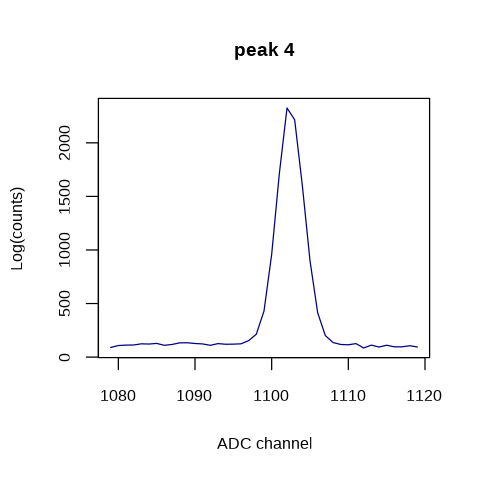

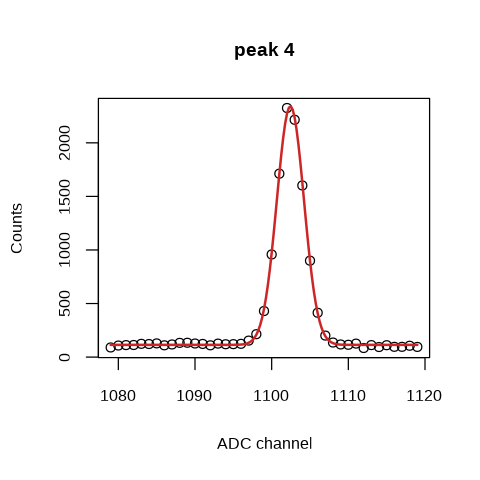

In [57]:
i=1
for (pk in peaks){

#Plot of the choosen peak
set_plot_dimensions(4, 4)
plot(pk$x,pk$y, type="l",
    pch = 1, cex=0.5, col="navy",
    ylab = "Log(counts)", xlab ="ADC channel",
    main=paste("peak",i))

A.min <- min(pk$y)
A.max <- max(pk$y)
B.min <- 0
B.max <- min(pk$y)
x0.min <- min(pk$x)
x0.max <- max(pk$x)

cat("model{

    #The likelihood:

    for (i in 1:length(x)){
        S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)

        y[i] ~ dpois(S[i]) 
    } 


    # Priors for  A, B, x0, w

    A ~ dunif(",A.min,",",A.max,")
    B ~ dunif(",B.min,",",B.max*1.5,")

    x0 ~ dunif(",x0.min,",",x0.max,")
    w ~ dunif(1,10)
      
}", file=paste("Models/test",i,".bug",sep=""))

model <- paste("Models/test",i,".bug",sep="")


#If multiple chains are run, each of them need to be initialized
init <- NULL;init$A  <- (A.max-A.min)/2
init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

#To have absolute control we also set the seed for and random number generator for each chain
init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 3713,.RNG.name = "base::Wichmann-Hill"),
             c(init,.RNG.seed  = 3714,.RNG.name = "base::Wichmann-Hill"))


chain_number <- 3
burnin       <- 1000
iterations   <- 1.e4
thining      <- 10


jm <- jags.model(model,
                 pk,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

#Update the Markov chain (Burn-in)
update(jm, burnin)

chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)


#Generate the chain and posterior plots
options(repr.plot.width = 10, repr.plot.height = 10)
#plot(chain)
print(paste("peak",i))
print(summary(chain))

A  <- summary(chain)$statistics[1]
B  <- summary(chain)$statistics[2]
w  <- summary(chain)$statistics[3]
x0  <- summary(chain)$statistics[4]
x <- seq(x0.min,x0.max,0.25)
f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


set_plot_dimensions(4, 4)
plot(pk$x,pk$y,
    ylab = "Counts", xlab ="ADC channel",
    main=paste("peak",i))
lines(x,f, lwd=2, col='firebrick3')
i=i+1
}

## Energy calibration

## Resolution study